## 1. Vanilla GAN
*     Reference. https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/generative_adversarial_network/main.py, https://github.com/Yangyangii/pytorch-practice/blob/master/GAN.ipynb, https://arxiv.org/pdf/1406.2661

In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import numpy as np
import datetime
import os
import sys
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [2]:
MODEL_NAME = 'GAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE) # generate 100 random noise vector -> generator가 이를 이용해 fake image generate
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28), generated image by the generator
    result = y_hat.cpu().data.numpy() # tensor to numpy
    img = np.zeros([280, 280])
    for j in range(10): # arrange images in 10x10 grid
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return img

In [4]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__() # to initialize the necessary components of the PyTorch module, 상속받는 class를 불러옴
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, x): # flattens the input image and passes it through the network layers
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

In [5]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )

    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [6]:
n_noise = 100 # size of noise vector

In [7]:
D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

In [8]:
# data processisng
# define transformations for MNIST dataset: normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

In [9]:
# load the MNIST dataset
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 40626592.78it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1103571.14it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9459181.54it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5114235.91it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [10]:
batch_size = 64
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)
# drop_last=True : drop the last incomplete batch if the dataset size is not divisible by the batch size

In [11]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [12]:
max_epoch = 50 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # number of times the discriminator is updated for each generator update -> D 한 번 업데이트 시 G도 한 번 업데이트

In [13]:
 # the target labels for the discriminator when it is given real images
 # a tensor of shape (batch_size, 1) filled with ones
 # indicate that these are real images, as the discriminator aims to output a probability of 1 for real images
D_labels = torch.ones(batch_size, 1).to(DEVICE)

# the target labels for the discriminator when it is given fake images
# a tensor of shape (batch_size, 1) filled with zeros
# indicate that these are fake images, as the discriminator aims to output a probability of 0 for fake images
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [14]:
if not os.path.exists('samples'): # to ensure that a directory named 'samples'
    os.makedirs('samples')

In [15]:
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE) #  real images batch
        x_outputs = D(x) # the discriminator's output for real images
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z)) # the discriminator's output for the fake images generated by the generator
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0: # step 이 n_critic 의 배수일 때만 조건문이 참 (이 코드의 경우 D, G 번갈아가면서 진행)
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE) # generate random noise vector
            z_outputs = D(G(z)) # generate fake images
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()

        # every 500 steps, the current epoch, step, and losses for the discriminator and generator are printed
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        # every 1000 steps, sample images generated by the generator are saved
        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/50, Step: 0, D Loss: 1.44820237159729, G Loss: 0.7000822424888611
Epoch: 0/50, Step: 500, D Loss: 1.2651424407958984, G Loss: 0.7910856008529663
Epoch: 1/50, Step: 1000, D Loss: 1.1365774869918823, G Loss: 1.162644386291504
Epoch: 1/50, Step: 1500, D Loss: 1.2702186107635498, G Loss: 1.0825258493423462
Epoch: 2/50, Step: 2000, D Loss: 1.2150282859802246, G Loss: 1.232478141784668
Epoch: 2/50, Step: 2500, D Loss: 1.179726243019104, G Loss: 0.705450177192688
Epoch: 3/50, Step: 3000, D Loss: 1.3237433433532715, G Loss: 0.9677579402923584
Epoch: 3/50, Step: 3500, D Loss: 1.2306663990020752, G Loss: 1.4082943201065063
Epoch: 4/50, Step: 4000, D Loss: 1.260117769241333, G Loss: 0.9935984015464783
Epoch: 4/50, Step: 4500, D Loss: 1.303587794303894, G Loss: 0.7236510515213013
Epoch: 5/50, Step: 5000, D Loss: 1.2783526182174683, G Loss: 0.741021990776062
Epoch: 5/50, Step: 5500, D Loss: 1.3010313510894775, G Loss: 0.6736865639686584
Epoch: 6/50, Step: 6000, D Loss: 1.1695003509521484, 

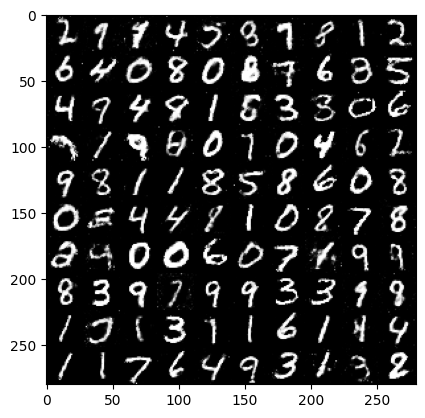

In [16]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [17]:
# for saving the trained model parameters of the discriminator (D) and the generator (G) after the training process is completed
torch.save(D.state_dict(), 'D.pkl')
torch.save(G.state_dict(), 'G.pkl')

### Question 1. Explain the code of the '1. Vanilla GAN' section "briefly".